# Competition where metric is rmse of log of prices
[Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv)

In [1]:
# Set up code checking
# Set up filepaths
import os
os.chdir(os.path.join(os.path.expanduser('~'), 'kaggle'))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load data into dataframes

In [3]:
train_path = os.path.join('data', 'house-prices-advanced-regression', 'train.csv')
train_data = pd.read_csv(train_path)

test_path = os.path.join('data', 'house-prices-advanced-regression', 'test.csv')
test_data_original = pd.read_csv(test_path)

## 1.1 Identify numeric and categorical features 

In [4]:
y = np.log(train_data['SalePrice'])
train_data.drop(columns=['SalePrice', 'Id'], inplace=True)
test_data = test_data_original.drop(columns=['Id'])

# remove stupid columns
train_data.drop(columns=['LowQualFinSF'], inplace=True)
test_data.drop(columns=['LowQualFinSF'], inplace=True)

numerical_columns = train_data.select_dtypes(include=np.number).columns.tolist()

numerical_columns.remove('MSSubClass')

categorical_columns = [c for c in train_data.columns if c not in numerical_columns]

print(train_data.shape, test_data.shape)

(1460, 78) (1459, 78)


## 1.2 Identify columns with roughly gaussian distributions 

In [8]:
# fig = train_data.hist(column=numerical_columns, figsize=(20, 20), rwidth=0.9)

gaussable_columns = [
    'LotFrontage',
    'OverallQual',
    'OverallCond',
    'TotalBsmtSF',
    '1stFlrSF', 
    '2ndFlrSF', 
    'GrLivArea',
    'BedroomAbvGr',
    'TotRmsAbvGrd',
    'GarageArea'
]

## 1.3 Create smaller pipelines for preprocessing 

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from category_encoders import TargetEncoder 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# adds additional column which indicates whether data was missing for given feature
class AddMissingIndicator(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.num_cols_with_na = [] 

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        self.num_cols_with_na = [c for c in df.columns if df[c].isna().any()]
        return self
    
    def transform(self, X, y=None) -> pd.DataFrame:
        df_to_transform = pd.DataFrame(X)
        for c in self.num_cols_with_na:
            missing_col_name = f"{c}_is_missing"
            df_to_transform[missing_col_name] = np.where(X[c].isna(), 1, 0) 
        
        return df_to_transform 

target_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), 
    ('target_encoding', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# for cat boost
ohe_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), 
    ('OHE', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# small cardinality columns get OHE, large get target encoding
# small_cardinality_cat_columns = [c for c in categorical_columns if len(set(train_data[c])) < 5]

# large_cardinality_cat_columns = [c for c in categorical_columns if c not in small_cardinality_cat_columns]

# normal_numeric_columns = [c for c in numerical_columns if c not in gaussable_columns]

standard_num_pipeline = Pipeline(steps=[
    ('missing_indicator', AddMissingIndicator()),
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

gauss_num_pipeline = Pipeline(steps=[
    ('missing_indicator', AddMissingIndicator()),
    ('imputer', SimpleImputer(strategy='median')), 
    ('power_scaler', PowerTransformer())
])

# preprocessing = ColumnTransformer(transformers=[
#     ('normal_numerical', standard_num_pipeline, normal_numeric_columns),
#     ('gauss_numerical', gauss_num_pipeline, gaussable_columns),
#     ('target_categorical', target_cat_pipeline, large_cardinality_cat_columns), 
#     ('OHE_categorical', ohe_cat_pipeline, small_cardinality_cat_columns), 
# ])

# 2. EDA
## 2.1 Mutual info with target

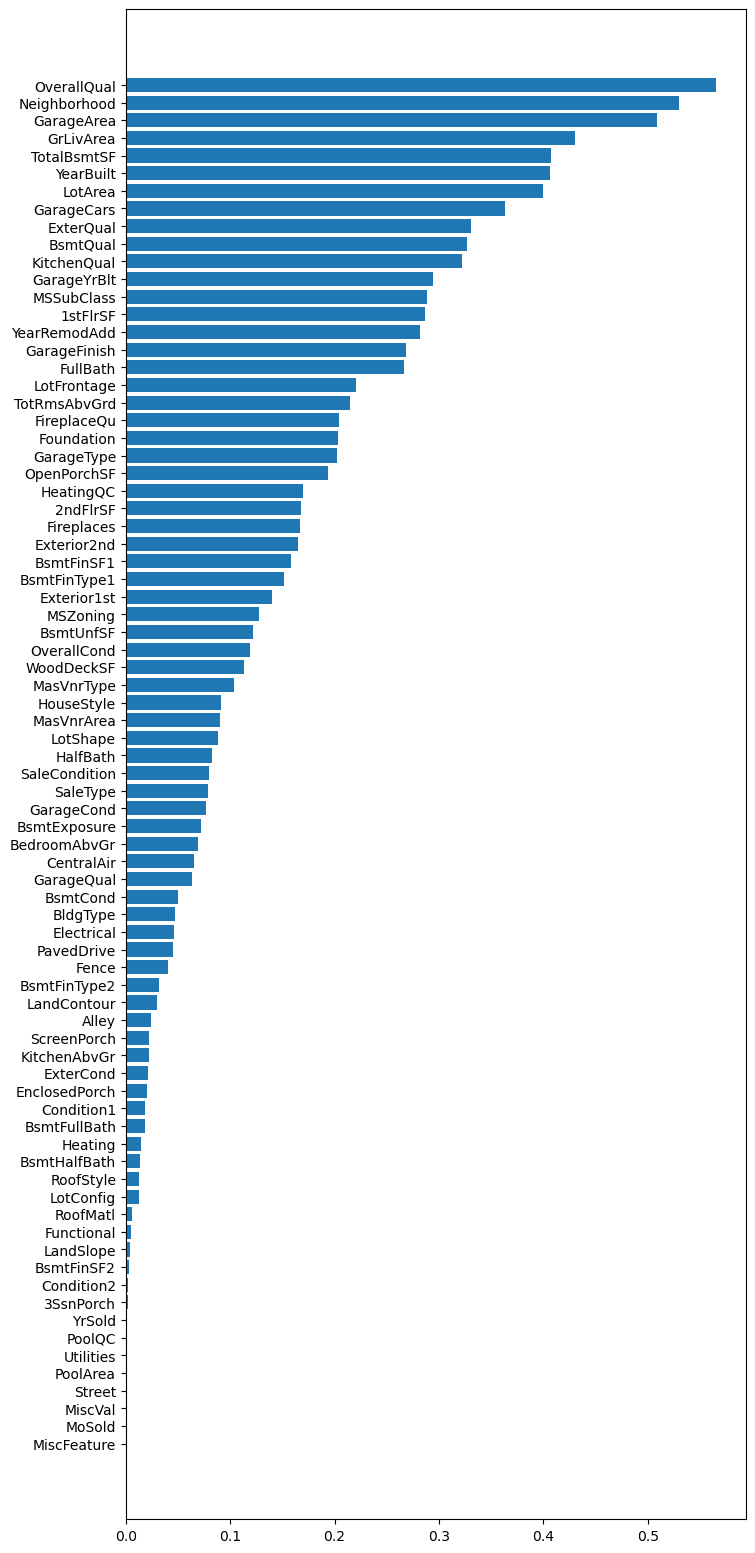

In [7]:
from sklearn.feature_selection import mutual_info_regression

factorized_df: pd.DataFrame = train_data.copy(deep=True)
# imputer for numerical columns
for c in numerical_columns:
    factorized_df[c] = factorized_df[c].fillna(factorized_df[c].median())

for c in categorical_columns:
    factorized_df[c] = pd.factorize(factorized_df[c])[0]


mi_scores = mutual_info_regression(factorized_df, y, discrete_features=(factorized_df.dtypes==int))

mi_scores = pd.Series(mi_scores, index=factorized_df.columns)
mi_scores = mi_scores.sort_values(ascending=True)

# print(mi_scores)

# plot mi scores
y_pos = np.arange(len(factorized_df.columns))

plt.figure(dpi=100, figsize=(8, 20))
plt.barh(y_pos, mi_scores)
plt.yticks(y_pos, labels=mi_scores.index)
plt.show()


## 2.2 Create new features

In [45]:
# add missing indicator and impute (no transformations)
numeric_imputer = Pipeline(steps=[
    ('missing_indicator', AddMissingIndicator()),
    ('imputer', SimpleImputer(strategy='median')), 
])

categoric_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), 
])

imputing_transformer = ColumnTransformer(transformers=[
    ('numeric_imputer', numeric_imputer, numerical_columns),
    ('categoric_imputer', categoric_imputer, categorical_columns)
])



## Test different regression models

In [46]:
from sklearn.linear_model import Lasso, Ridge, BayesianRidge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor


models = {
    'ridge': Ridge(),
    'lasso': Lasso(random_state=1),
    'xgboost': XGBRegressor(random_state=1, eval_metric='rmse'),
    # 'GBR': GradientBoostingRegressor(loss='squared_error', random_state=1),
    'lgbm': LGBMRegressor(), 
    'cat_boost': CatBoostRegressor(silent=True), 
    'b_ridge': BayesianRidge(), 
    'hist_gbr': HistGradientBoostingRegressor()
}

pipelines = {key: Pipeline(steps=[
    ('preprocessing', preprocessing),
    (f'{key}', models[key])
]) for key in models}

# models['cat_boost'] = CatBoostRegressor(silent=True)

# pipelines['cat_boost'] = Pipeline(steps=[
#     ('preprocessing_no_ohe', preprocessing_no_ohe), 
#     ('cat_boost', models['cat_boost'])
# ])

def get_rmse(predictor, X, y):
    return -cross_val_score(predictor, X, y, scoring='neg_root_mean_squared_error', cv=5).mean()


for p in pipelines:
    predictor = pipelines[p]
    mae = get_rmse(predictor, train_data, y)
    print(f"Model: {p}")
    print(f'RMSE: {mae}')
    print()


Model: ridge
RMSE: 0.1328379901771169

Model: lasso
RMSE: 0.3992282792085989

Model: xgboost
RMSE: 0.1394369142648041

Model: lgbm
RMSE: 0.13256667689915594

Model: cat_boost
RMSE: 0.11898162164812096

Model: b_ridge
RMSE: 0.12952290582498044

Model: hist_gbr
RMSE: 0.1319250093686956



## GridSearchCV parameters for models with small number of params

In [52]:
import optuna
from copy import deepcopy

optuna.logging.set_verbosity(0)

def ridge_cost(trial):
    alpha = trial.suggest_loguniform('ridge__alpha', 10, 100)
    tol = trial.suggest_loguniform('ridge__tol', 1e-7, 1e-4)
    pipe = deepcopy(pipelines['ridge'])
    pipe.set_params(**{
        'ridge__alpha': alpha, 
        'ridge__tol': tol
    })
    return get_rmse(pipe, train_data, y)

def lasso_cost(trial):
    alpha = trial.suggest_loguniform('lasso__alpha', 1e-4, 1)
    tol = trial.suggest_loguniform('lasso__tol', 1e-5, 1e-3)
    pipe = deepcopy(pipelines['lasso'])
    pipe.set_params(**{
        'lasso__alpha': alpha, 
        # 'lasso__tol': tol
    })
    return get_rmse(pipe, train_data, y)

## Get most important features for other models


In [53]:
from optuna.integration import LightGBMPruningCallback

def xgboost_cost(trial: optuna.trial.Trial):
    pipe = deepcopy(pipelines['xgboost'])

    pipe.set_params(**{
        'xgboost__max_depth': trial.suggest_int('max_depth', 1, 4), 
        'xgboost__min_child_weight': trial.suggest_int('min_cw', 0, 10), 
        'xgboost__colsample_bytree': trial.suggest_float('cs_bt', 0, 1),
        'xgboost__n_estimators': trial.suggest_int('n_est', 50, 800), 
        'xgboost__reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'xgboost__subsample': trial.suggest_float('subsample', 0, 1), 
        'xgboost__reg_alpha': trial.suggest_float('alpha', 0, 1),
        'xgboost__eval_metric': 'rmse'
    })

    return get_rmse(pipe, train_data, y)


In [54]:
# def lgbm_cost(trial: optuna.trial.Trial):
#     pipe = deepcopy(pipelines['lgbm'])
#     pipe.set_params(**{
#         # "lgbm__num_iterations": trial.suggest_int('num_iterations', 50, 300),
#         "lgbm__learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "lgbm__num_leaves": trial.suggest_int("num_leaves", 20, 300),
#         # "lgbm__max_depth": trial.suggest_int("max_depth", 3, 12),
#         "lgbm__min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
#         # "lgbm__max_bin": trial.suggest_int("max_bin", 200, 300),
#         # "lgbm__lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
#         # "lgbm__lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
#         "lgbm__min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#         # "lgbm__bagging_fraction": trial.suggest_float(
#         #     "bagging_fraction", 0.2, 0.95
#         # ),
#         # "lgbm__bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
#         # "lgbm__feature_fraction": trial.suggest_float(
#         #     "feature_fraction", 0.5, 0.95
#         # ),
#         'lgbm__early_stopping_rounds': 100,
#         # 'lgbm__callbacks': [LightGBMPruningCallback(trial, 'rmse')]
#     })

#     return get_rmse(pipe, train_data, y)

In [66]:
def catboost_cost(trial: optuna.trial.Trial):
    pipe = deepcopy(pipelines['cat_boost'])
    pipe.set_params(**{
        "cat_boost__colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "cat_boost__depth": trial.suggest_int("depth", 4, 10),
        "cat_boost__boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "cat_boost__bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "cat_boost__eval_metric": "RMSE",
    })

    return get_rmse(pipe, train_data, y)

In [67]:
def b_ridge_cost(trial: optuna.trial.Trial):
    pipe = deepcopy(pipelines['b_ridge'])
    pipe.set_params(**{
        'b_ridge__n_iter': trial.suggest_int('n_iter', 100, 1000, log=True), 
        'b_ridge__alpha_1': trial.suggest_float('alpha1', 1e-9, 1e-3, log=True),
        'b_ridge__alpha_2': trial.suggest_float('alpha2', 1e-9, 1e-3, log=True),
    })

    return get_rmse(pipe, train_data, y)

In [68]:
def hist_gbr_cost(trial: optuna.trial.Trial):
    pipe = deepcopy(pipelines['hist_gbr'])
    pipe.set_params(**{
        'hist_gbr__max_iter': trial.suggest_int('max_iter', 50, 500),
        'hist_gbr__max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 5, 50), 
    })
    return get_rmse(pipe, train_data, y)

In [71]:

functions = {
    # 'ridge': ridge_cost, 
    # 'lasso': lasso_cost,
    # 'xgboost': xgboost_cost, 
    # 'lgbm': lgbm_cost,
    # 'cat_boost': catboost_cost,
    # 'b_ridge': b_ridge_cost,
    'hist_gbr': hist_gbr_cost,
}

for name in functions:
    study = optuna.create_study()
    study.optimize(functions[name], n_trials=20, show_progress_bar=True)
    print(f'Model {name}')
    print(f'Best params: {study.best_params}')
    print(f'Best score: {study.best_value}')
    print(optuna.importance.get_param_importances(study))
    print()


/home/vasil/earth-analytics-parent/earth-analytics/conda-env/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
100%|██████████| 20/20 [16:53<00:00, 50.67s/it]


Model hist_gbr
Best params: {'max_iter': 306, 'max_leaf_nodes': 5}
Best score: 0.12736518003286176
OrderedDict([('max_leaf_nodes', 0.9464325642567691), ('max_iter', 0.05356743574323084)])



In [75]:
from sklearn.ensemble import VotingRegressor
final_best_params = {}

final_best_params['xgboost'] = {
    'xgboost__eval_metric': 'rmse', 
    # 'xgboost__max_depth': 2, 
    # 'xgboost__n_estimators': 418,
    # 'xgboost__min_child_weight': 1, 
    # 'xgboost__gamma': 0.0, 
    # 'xgboost__colsample_bytree': 0.16, 
    # 'xgboost__subsample': 0.78, 
    # 'xgboost__reg_alpha': 0.37,
    # 'xgboost__reg_lambda': 0.25

    'xgboost__max_depth': 2, 
    'xgboost__min_child_weight': 3, 
    'xgboost__colsample_bytree': 0.2049030222473224, 
    'xgboost__n_estimators': 479, 
    'xgboost__reg_lambda': 0.2824862837800328, 
    'xgboost__subsample': 0.9561978086541947, 
    'xgboost__alpha': 0.8384411117820882
}

# final_best_params['lasso'] = {
#     'lasso__alpha': 0.00048686724495962007, 
#     # 'lasso__tol': 1.8644218591611686e-05
# }

# final_best_params['GBR'] = {
#     'GBR__loss': 'squared_error', 
#     'GBR__n_estimators': 380, 
#     'GBR__random_state': 1, 
#     'GBR__subsample': 1, 
#     'GBR__max_depth': 4, 
#     'GBR__min_samples_split': 8 
# }

final_best_params['ridge'] = {
    'ridge__alpha': 10.013030924397276, 
    'ridge__tol': 5.943295651368705e-06
}

final_best_params['lgbm'] = {}

final_best_params['cat_boost'] = {} # no improvement over default params

final_best_params['b_ridge'] = {}

final_best_params['hist_gbr'] = {
    'hist_gbr__max_leaf_nodes': 5, 
    'hist_gbr__max_iter': 306
}

list_of_models = []
scores = []
for pipe_name in final_best_params:
    # set the corresponding model with the optimal parameters
    pipelines[pipe_name] = pipelines[pipe_name].set_params(**final_best_params[pipe_name])
    pipe = pipelines[pipe_name]
    list_of_models.append((pipe_name, pipe))
    rmse = get_rmse(pipe, train_data, y)
    scores.append(-rmse)
    print(f'Model {pipe_name}: rmse {rmse:.5f}')

weights = [min(scores)/score for score in scores]

final_estimator = VotingRegressor(list_of_models, weights=weights)
print(f'Ensemble model rmse: {get_rmse(final_estimator, train_data, y):.5f}')

Model xgboost: rmse 0.12474
Model ridge: rmse 0.12931
Model lgbm: rmse 0.13257
Model cat_boost: rmse 0.11898
Model b_ridge: rmse 0.12952
Model hist_gbr: rmse 0.12737
Ensemble model rmse: 0.11918


## Stacking model

In [76]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

# final_best_params['lasso'] = {
#     'lasso__alpha': 0.01, 
#     'lasso__tol': 0.0001
# }

print([i for i in final_best_params])
all_estimators = [(name, pipelines[name]) for name in final_best_params]
stacked_model = StackingRegressor(estimators=all_estimators)

print('Stacked model')
print(f'RMSE: {get_rmse(stacked_model, train_data, y)}')

['xgboost', 'ridge', 'lgbm', 'cat_boost', 'b_ridge', 'hist_gbr']
Stacked model
RMSE: 0.11984498936945749


## Generate final submission 

In [14]:
final_predictions = stacked_model.fit(train_data, y).predict(test_data)
print(np.exp(final_predictions).shape, test_data_original['Id'].shape)
output = pd.DataFrame({'Id': test_data_original.Id,
                    'SalePrice': np.exp(final_predictions)})
output.to_csv(f'code/house-prices-advanced-regression/big_ensemble_model_2.csv', index=False)

(1459,) (1459,)
